## Autoencoders

Un autoencoder es un tipo de red neuronal utilizada principalmente para tareas de compresión de datos y reducción de dimensionalidad. Su arquitectura consta de dos partes principales:

- Codificador (Encoder): comprime los datos de entrada en una representación de menor dimensión, conocida como el espacio latente o embebido.
- Decodificador (Decoder): reconstruye los datos originales a partir de esta representación comprimida.

El objetivo principal de un autoencoder es minimizar la diferencia entre los datos de entrada y los datos reconstruidos.
El cometido es utilizar esta red para realizar dos tareas diferentes, un sistema de eliminación de ruido y un generador de imágenes de superresolución.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [3]:
transform = transforms.ToTensor()

mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
data_loader = torch.utils.data.DataLoader(dataset=mnist_data,
                                          batch_size=64,
                                          shuffle=True)

mnist_data_valid = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
data_loader_valid = torch.utils.data.DataLoader(dataset=mnist_data_valid,
                                          batch_size=64,
                                          shuffle=True)         

In [4]:
dataiter = iter(data_loader)
images, labels = next(dataiter)
print(torch.min(images), torch.max(images))

tensor(0.) tensor(1.)


#### Estructura del autoencoder (No Lineal):

In [5]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [6]:
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3, 
                             weight_decay=1e-5)

In [7]:
num_epochs = 10
outputs = []
for epoch in range(num_epochs):
    for (img, _) in data_loader:
        recon = model(img)
        loss = criterion(recon, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))

Epoch:1, Loss:0.0078
Epoch:2, Loss:0.0053
Epoch:3, Loss:0.0040
Epoch:4, Loss:0.0047
Epoch:5, Loss:0.0033
Epoch:6, Loss:0.0029
Epoch:7, Loss:0.0032
Epoch:8, Loss:0.0030
Epoch:9, Loss:0.0031
Epoch:10, Loss:0.0025


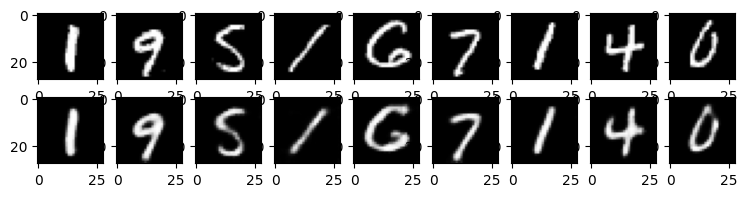

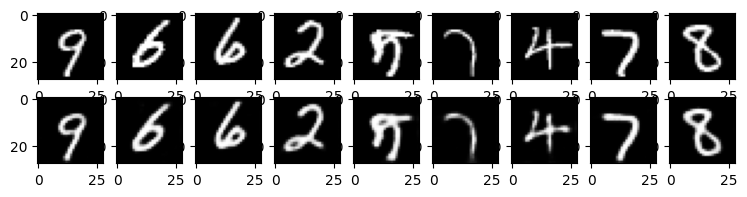

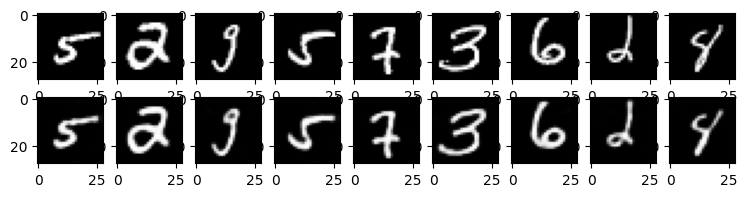

In [8]:
for k in range(0, num_epochs, 4):
    plt.figure(figsize=(9, 2))
    plt.gray()
    
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()

    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        plt.imshow(item[0])
            
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1)
        plt.imshow(item[0])

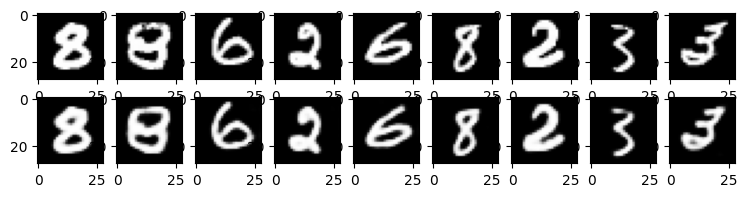

In [9]:
model.eval()

dataiter = iter(data_loader_valid)
images, labels = next(dataiter)

plt.figure(figsize=(9, 2))
plt.gray()


for i, img in enumerate(images[:9]):
    with torch.no_grad():
        pred = model(img.unsqueeze(0))
        recon = pred[0].detach().numpy()

        plt.subplot(2, 9, i+1)
        plt.imshow(img[0])

        plt.subplot(2, 9, i+1+9)
        plt.imshow(recon[0])

### Eliminación de ruido

Utilizando la estructura del autoencoder anterior añadimos ruido gaussiano a las imágenes de entrada. Las imágenes de salida las compararemos con las imágenes originales.

Epoch:1, Loss:0.0194
Epoch:2, Loss:0.0160
Epoch:3, Loss:0.0147
Epoch:4, Loss:0.0134
Epoch:5, Loss:0.0128
Epoch:6, Loss:0.0122
Epoch:7, Loss:0.0105
Epoch:8, Loss:0.0122
Epoch:9, Loss:0.0108
Epoch:10, Loss:0.0102
Epoch:11, Loss:0.0111
Epoch:12, Loss:0.0111
Epoch:13, Loss:0.0110
Epoch:14, Loss:0.0118
Epoch:15, Loss:0.0101
Epoch:16, Loss:0.0099
Epoch:17, Loss:0.0118
Epoch:18, Loss:0.0102
Epoch:19, Loss:0.0098
Epoch:20, Loss:0.0107
Epoch:21, Loss:0.0119
Epoch:22, Loss:0.0115
Epoch:23, Loss:0.0105
Epoch:24, Loss:0.0108
Epoch:25, Loss:0.0116
Epoch:26, Loss:0.0099
Epoch:27, Loss:0.0115
Epoch:28, Loss:0.0094
Epoch:29, Loss:0.0105
Epoch:30, Loss:0.0101
Epoch:31, Loss:0.0110
Epoch:32, Loss:0.0103
Epoch:33, Loss:0.0112
Epoch:34, Loss:0.0109
Epoch:35, Loss:0.0106
Epoch:36, Loss:0.0107
Epoch:37, Loss:0.0111
Epoch:38, Loss:0.0099
Epoch:39, Loss:0.0101
Epoch:40, Loss:0.0116
Epoch:41, Loss:0.0105
Epoch:42, Loss:0.0108
Epoch:43, Loss:0.0111
Epoch:44, Loss:0.0118
Epoch:45, Loss:0.0110
Epoch:46, Loss:0.01

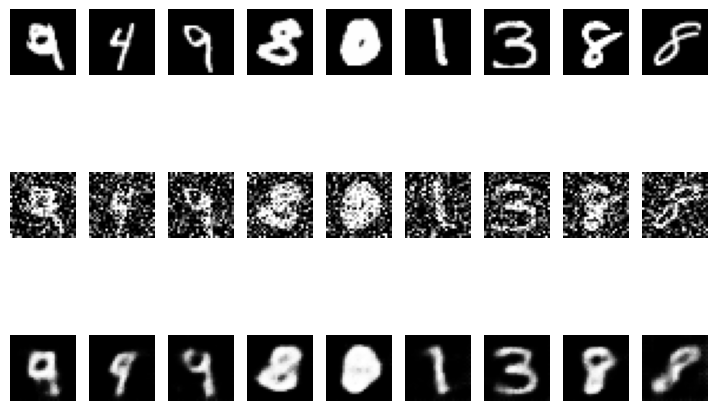

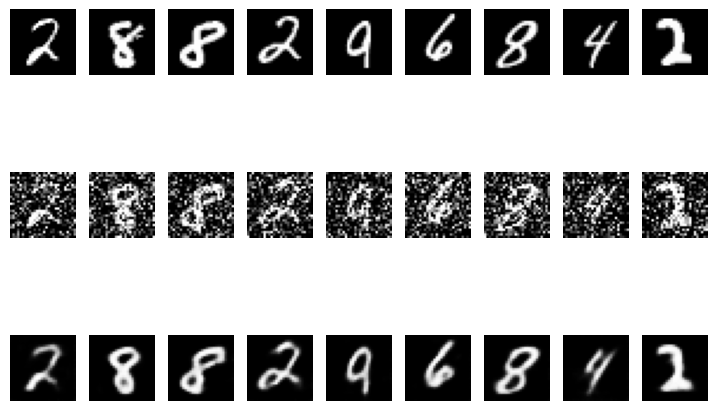

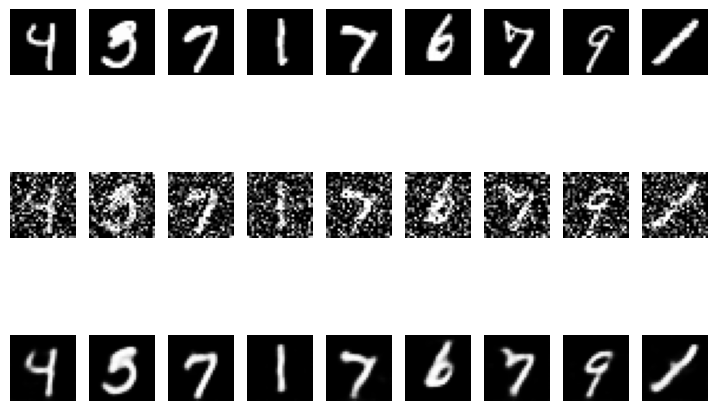

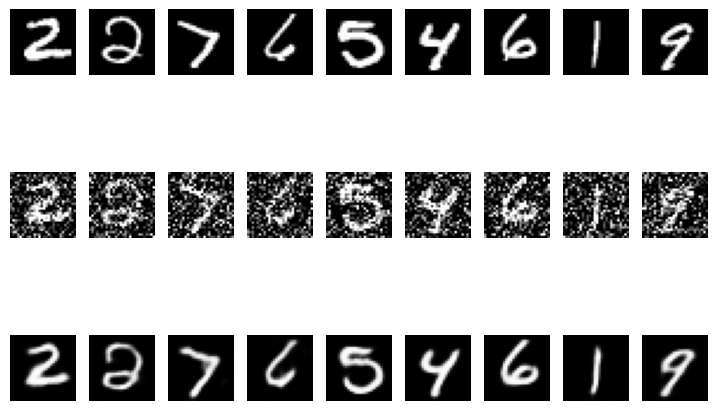

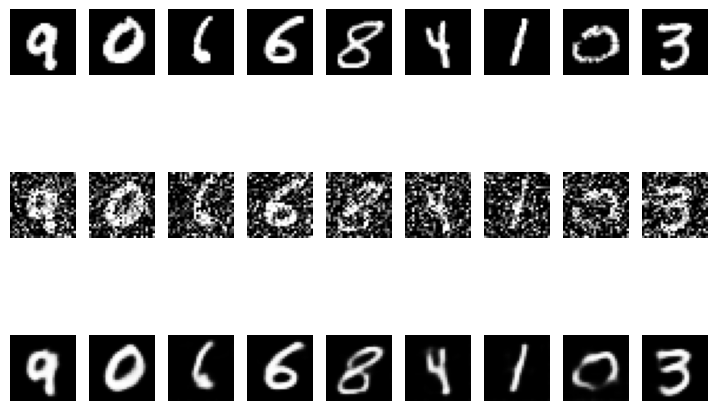

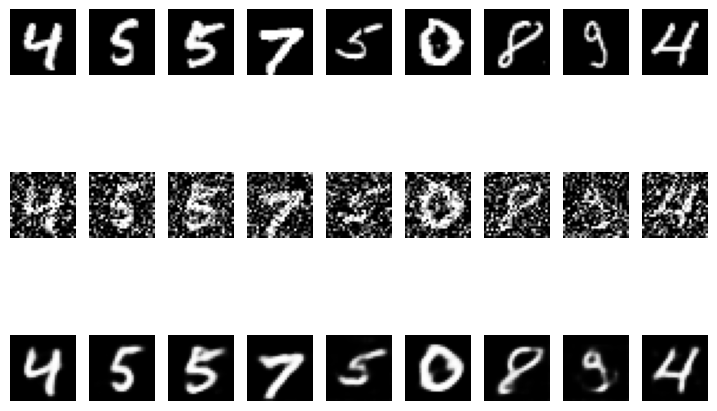

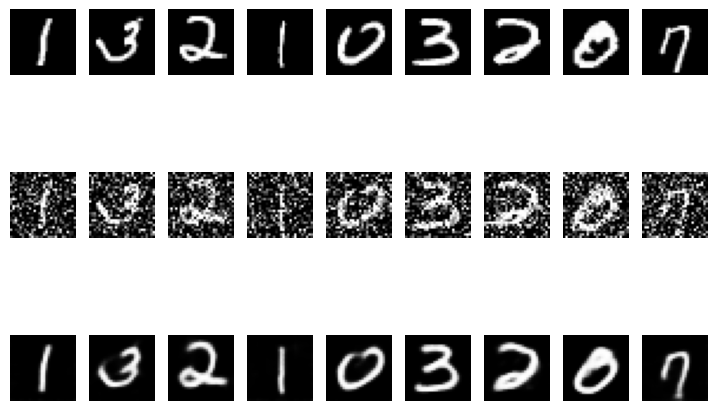

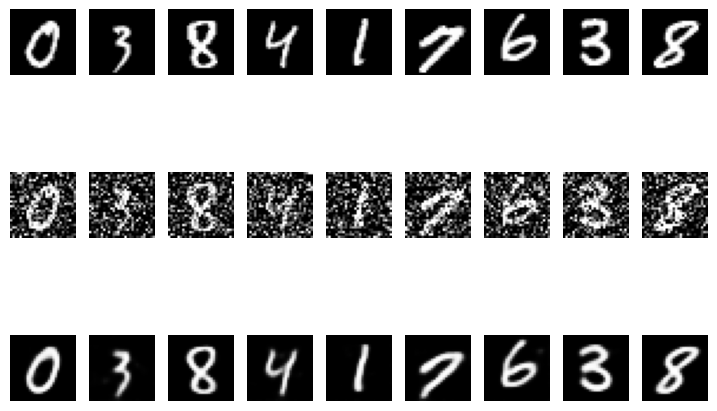

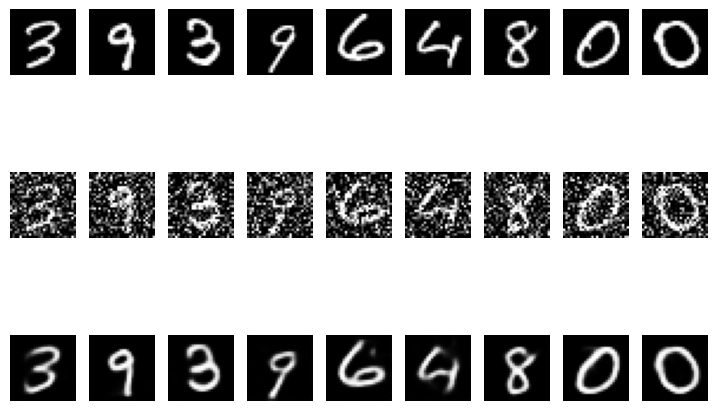

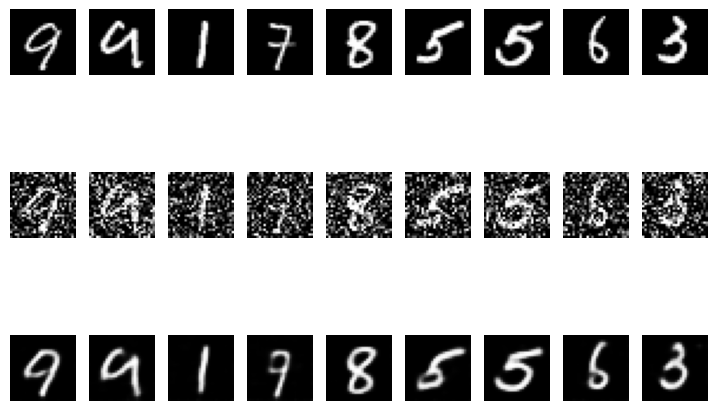

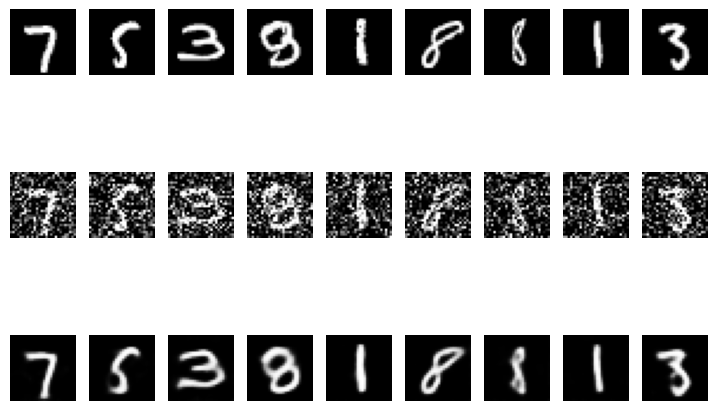

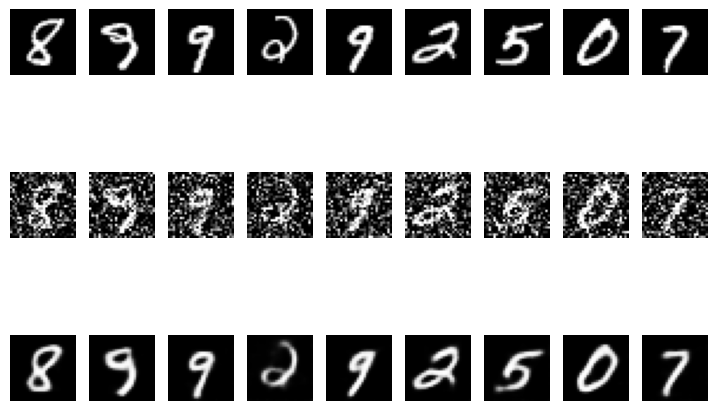

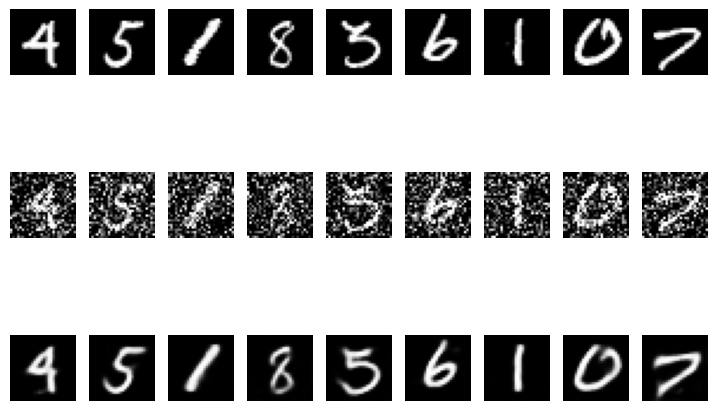

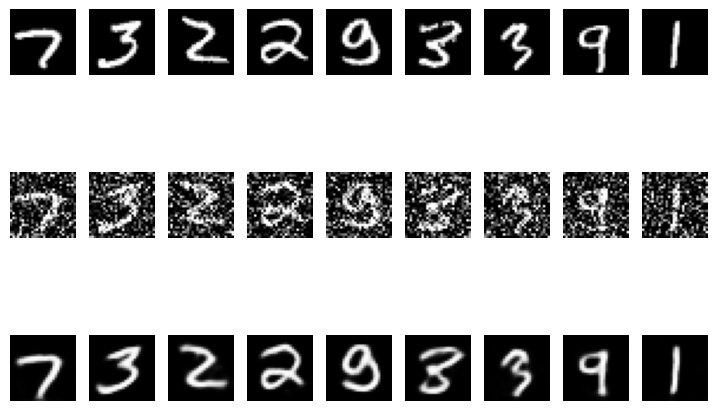

In [10]:

model = Autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3, 
                             weight_decay=1e-5)

noise_std = 0.5
num_epochs = 50
outputs = []

for epoch in range(num_epochs):
    for (img, _) in data_loader:
        noise = torch.randn_like(img) * noise_std
        noisy_img = img + noise
        noisy_img = torch.clamp(noisy_img, 0., 1.)
        recon = model(noisy_img)
        loss = criterion(recon, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img.detach(), noisy_img.detach(), recon.detach()))


for k in range(0, num_epochs, 4):
    plt.figure(figsize=(9, 6))
    plt.gray()
    
    clean = outputs[k][1].numpy()
    noisy = outputs[k][2].numpy()
    recon = outputs[k][3].numpy()
    for i in range(9):
        plt.subplot(3, 9, i+1)
        plt.axis('off')
        plt.imshow(clean[i][0])

        plt.subplot(3, 9, 9+i+1)
        plt.axis('off')
        plt.imshow(noisy[i][0])

        plt.subplot(3, 9, 18+i+1)
        plt.axis('off')
        plt.imshow(recon[i][0])

model.eval()

dataiter = iter(data_loader_valid)
images, labels = next(dataiter)

plt.figure(figsize=(9, 6))
plt.gray()

for i, img in enumerate(images[:9]):
    with torch.no_grad():
        img = img.unsqueeze(0)
        noise = torch.randn_like(img) * noise_std
        noisy_img = img + noise
        noisy_img = torch.clamp(noisy_img, 0., 1.)
        pred = model(noisy_img)
        recon = pred[0].detach().numpy()
        noisy_np = noisy_img[0].detach().numpy()
        clean_np = img[0].detach().numpy()
        plt.subplot(3, 9, i+1)
        plt.axis('off')
        plt.imshow(clean_np[0])

        plt.subplot(3, 9, 9+i+1)
        plt.axis('off')
        plt.imshow(noisy_np[0])

        plt.subplot(3, 9, 18+i+1)
        plt.axis('off')
        plt.imshow(recon[0])

plt.show()


### Superresolución

Para esa parte deberermos modificar la arquitectura del autoencoder para que admita imágenes de 7x7 y de 14x14 pixels y genere imágenes de 28x28. El objetivo es aumentar artificialmente la resolución de las imágenes.

Epoch:1, Loss:0.0114
Epoch:2, Loss:0.0073
Epoch:3, Loss:0.0062
Epoch:4, Loss:0.0057
Epoch:5, Loss:0.0042
Epoch:6, Loss:0.0040
Epoch:7, Loss:0.0041
Epoch:8, Loss:0.0039
Epoch:9, Loss:0.0038
Epoch:10, Loss:0.0030


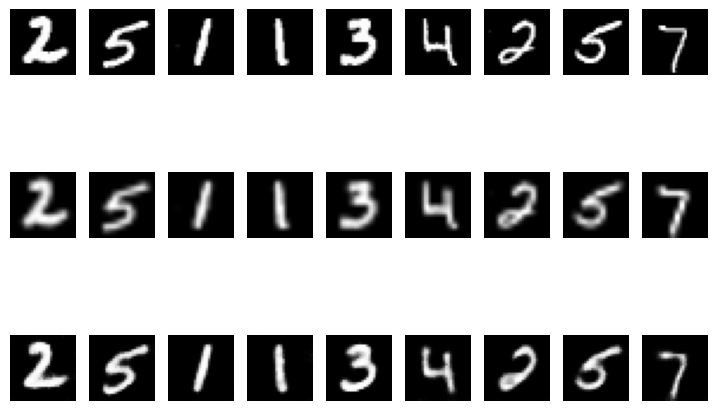

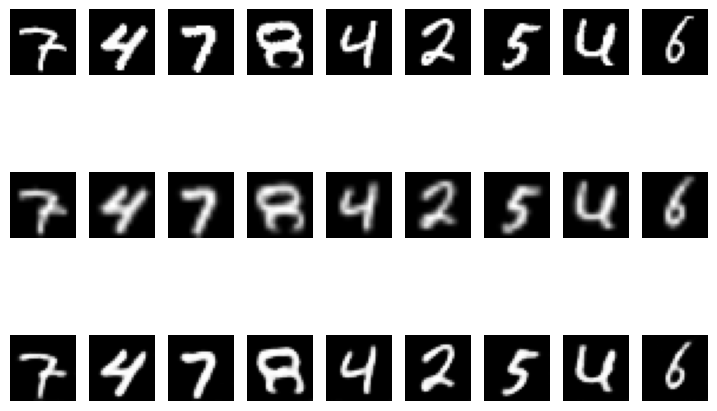

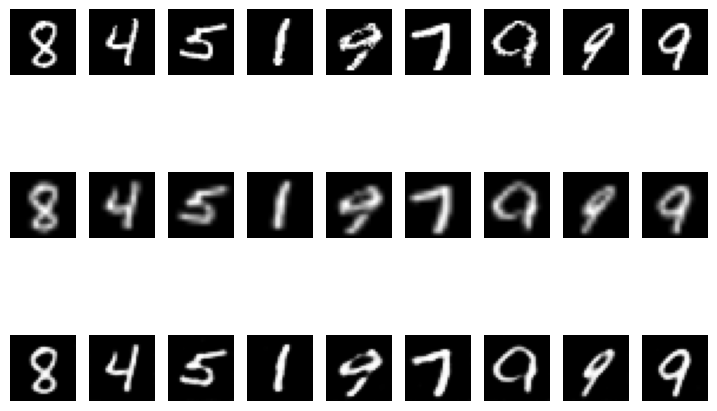

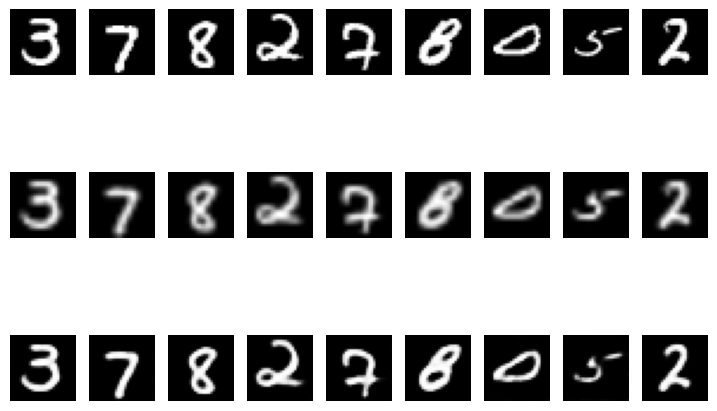

In [11]:
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3, 
                             weight_decay=1e-5)

num_epochs = 10
outputs = []

for epoch in range(num_epochs):
    for (img_hr, _) in data_loader:
        img_lr = F.interpolate(img_hr, scale_factor=0.5, mode='bilinear', align_corners=False)
        img_lr_up = F.interpolate(img_lr, size=(28, 28), mode='bilinear', align_corners=False)
        recon = model(img_lr_up)
        loss = criterion(recon, img_hr)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img_hr.detach(), img_lr_up.detach(), recon.detach()))

for k in range(0, num_epochs, 4):
    plt.figure(figsize=(9, 6))
    plt.gray()
    hr = outputs[k][1].numpy()
    lr_up = outputs[k][2].numpy()
    recon = outputs[k][3].numpy()
    for i in range(9):
        plt.subplot(3, 9, i+1)
        plt.axis('off')
        plt.imshow(hr[i][0])
        plt.subplot(3, 9, 9+i+1)
        plt.axis('off')
        plt.imshow(lr_up[i][0])
        plt.subplot(3, 9, 18+i+1)
        plt.axis('off')
        plt.imshow(recon[i][0])
plt.show()

model.eval()

dataiter = iter(data_loader_valid)
images, labels = next(dataiter)
plt.figure(figsize=(9, 6))
plt.gray()

for i, img_hr in enumerate(images[:9]):
    with torch.no_grad():
        img_hr = img_hr.unsqueeze(0)
        img_lr = F.interpolate(img_hr, scale_factor=0.5, mode='bilinear', align_corners=False)
        img_lr_up = F.interpolate(img_lr, size=(28, 28), mode='bilinear', align_corners=False)
        pred = model(img_lr_up)
        recon = pred[0].detach().numpy()
        lr_up_np = img_lr_up[0].detach().numpy()
        hr_np = img_hr[0].detach().numpy()
        plt.subplot(3, 9, i+1)
        plt.axis('off')
        plt.imshow(hr_np[0])
        plt.subplot(3, 9, 9+i+1)
        plt.axis('off')
        plt.imshow(lr_up_np[0])
        plt.subplot(3, 9, 18+i+1)
        plt.axis('off')
        plt.imshow(recon[0])

plt.show()
